<a href="https://colab.research.google.com/github/reejungkim/Pipeline/blob/main/prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import libraries

In [101]:
import warnings
warnings.filterwarnings("ignore")

# Load up packages
import os
import pandas as pd
import numpy as np
import sklearn

#visualization lisb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('Set2')

#split data set
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score

#feature selection
from sklearn import feature_selection

#preprocessing libs
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
#label encoders
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

#Models
#classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
#regressors
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor


#model evaluation libs
#classifier evaluation
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#regressor evaluation
from sklearn.metrics import r2_score, mean_squared_error

#number of features optimization
from sklearn.model_selection import StratifiedKFold

#Hyper-parameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Load data set

In [173]:
# Load data
#df = pd.read_csv('bankruptcy_Train.csv')

#df = sns.load_dataset('diamonds')
#df.head()


# Seaborn 데이터셋 목록
sns.get_dataset_names()

df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [224]:
pd.concat( [ df.dtypes.rename('dtype') , df.iloc[0].rename('example') ], axis=1 ) 

,dtype,example
survived,int64,0
pclass,int64,3
sex,object,male
age,float64,22.0
sibsp,int64,1
parch,int64,0
fare,float64,7.25
embarked,object,S
class,category,Third
who,object,man


In [174]:
features = df.loc[:, df.columns!='survived']
output = df.loc[:, df.columns=='survived']

# Split data set

In [175]:
X_train, X_test, y_train, y_test = train_test_split(features, output, 
                                                    test_size=0.2,
                                                    random_state=52)

# Exploratory Data Analysis

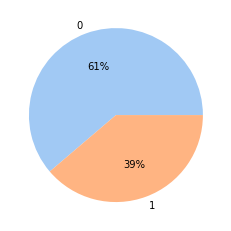

In [176]:
labels = [0,1]
sizes = [y_train['survived'].value_counts()[0],
         y_train['survived'].value_counts()[1]]

colors = sns.color_palette('pastel')
plt.pie(sizes, labels=labels,  autopct='%.0f%%', colors=colors)
plt.show()

In [177]:
# checking for sparse columns 
#(df.isnull().sum()/ len(df).sort_values(ascending=False)[:30]
df_null = pd.DataFrame((X_train.isnull().sum()/ len(X_train)), columns={"%missing"}).sort_values(by="%missing", ascending=False)
df_null.loc[df_null['%missing']>=.5]

,%missing
deck,0.759831


should check if the sparse columns refers to zero or n/a before dropping the columns
 

In [40]:
X_train.drop(['deck'], axis=1, inplace=True)

# Checking columns with small variations

In [125]:
sel = feature_selection.VarianceThreshold() #removes all features whose variance doesn’t meet some threshold. By default it removes features with zero variance or features that have the same value for all samples.
train_variance =  sel.fit_transform(X_train)
train_variance

ValueError: ignored

In [50]:
df_no_var = features.std().sort_values(ascending=True)
df_no_var#.loc[df_no_var<=0.2]

adult_male     0.489615
alone          0.489615
parch          0.806057
pclass         0.836071
sibsp          1.102743
age           14.526497
fare          49.693429
dtype: float64

In [10]:
#df.drop(['Attr1', 'Attr2'], axis=1)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  embark_town  891 non-null    object  
 12  alive        891 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(5)
memory usage: 79.4+ KB


# Imputer - Categorical columns

In [60]:
#catogory type
for col in ['class']:
  X_train[col]= X_train[col].cat.add_categories("F").fillna("F")

In [61]:
#replace null objects with 'None'
for col in ['fare']:
    X_train[col] = X_train[col].fillna("none")

In [62]:
cols_obj = X_train.select_dtypes(include=['object']).columns
# Impute null objects with mode
for col in cols_obj:
    #df[col] = df[col].fillna(df[col].mode()[0])
    X_train[col].fillna(df[col].mode()[0], inplace=True)

# Imputer - Numeric Columns

In [64]:
# imputer on columns where null value refers to zero instead of n/a
X_train[['fare', 'parch']] =  X_train[['fare', 'parch']].fillna(0)

In [65]:
cols_number = df.select_dtypes(include=['int64', 'float64']).columns
# Null values of rest of numerical types variables would better be replaced by median of neighborhood group
for col in cols_number:
    X_train[col] = X_train.groupby('class')[col].transform( lambda x: x.fillna(x.median()))

# Vectorization

In [66]:
for col in cols_obj:
    print('{}: {}'.format(col, df[col].unique()  ))

sex: ['male' 'female']
embarked: ['S' 'C' 'Q']
who: ['man' 'woman' 'child']
embark_town: ['Southampton' 'Cherbourg' 'Queenstown']
alive: ['no' 'yes']


In [67]:
#Encoding object type variables using label encoder
for col in cols_obj:
    df[col] = le.fit_transform(df[col])

# Pipeline

In [9]:
make_column_transformer(
    (StandardScaler(), ['carat', 'depth']),
    (OneHotEncoder(), ['cut']),
    remainder='passthrough'
)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['carat', 'depth']),
                                ('onehotencoder', OneHotEncoder(), ['cut'])])

In [257]:
num_pipeline = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
        ]
)

cat_pipeline = Pipeline(
    steps = [ 
        #('imputer_constant', SimpleImputer(strategy='constant', fill_value='none'),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")) 
        ]
)


In [258]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names   
    def fit( self, X, y = None ):
        return self
    def transform(self, X, y=None):
        return X.loc[:, self.feature_names].copy(deep=True)

In [262]:
# 수치형 특징의 리스트를 저장한다.
num_x_training = X_train.select_dtypes(include=['number', 'int64', 'float64'] )\
                            .columns \
                            .to_list()
# 범주형 특징의 리스트를 저장한다.
cat_x_training = X_train.select_dtypes(include=['object', 'category'])\
                            .columns \
                            .to_list()

# ColumnTranformer 로 열 변환자 객체 정의
preprocessor = ColumnTransformer([
    ('numeric', num_pipeline, num_x_training),
    ('categorical', cat_pipeline, cat_x_training)  #['sex', 'embarked', 'embark_town']) 
], remainder='drop')

In [263]:
full_pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', XGBClassifier())
    ]
)


preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
pd.DataFrame(X_train_transformed)


In [264]:
sklearn.set_config(display="diagram")
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['pclass', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'embarked', 'class',
                                                   'who', 'deck', 'embark_town',
                                                   'alive'])])),
                ('model', XGBClassifier())])

In [265]:
y_train_pred = full_pipeline.predict(X_train)

In [266]:
pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
             columns = ['predicted Negative', 'Predicted Positive'],
             index = ['Actual Negative', 'Actual Positive'])

,predicted Negative,Predicted Positive
Actual Negative,436,0
Actual Positive,0,276


In [267]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       436
           1       1.00      1.00      1.00       276

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712



In [270]:
y_pred = full_pipeline.predict(X_test)

In [271]:
print(classification_report( y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00        66

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



# Evaluation 

**Regression**
* R-Squared
* RMSE : Root Mean Squared Error [0- infinity]
* MAE : Mean Absolute Error [0- infinity]

**Classification**
* Accuracy
*Precision
*Recall
*Specificity
*F1 Score


* R-squared : how well the predictions approximate the  ground truth [0–100%]
*RMSE and MAE are more interpretable than R-squared and Using the RMSE is more appropriate if the data have a lot of outliers.
*Accuracy : This is a metric that is best used for a balanced data set
*Precision : This metric that’s be used to avoid false positive predict (observation is negative, but is predicted positive)
*Recall / Sensitivity : This metric that’s be used to avoid false negative (Observation is positive, but is predicted negative) and maximize True positive rate.
*Specificity : This metric is used to maximize True negative rate and minimize True positive rate.
*F1 Score : This metric that’s be used to minimize False positive and False negative (일반적으로 크래스 불균형 문제가 있을경우에는 정확도와 정밀도가 높고 재현율이 크게 떨어지는 경향이있음. 따서 정확도, 정밀도, 재현율 가운데 하나의 척도만 사용한다면 모델의 성능을 객관적으로 판단하기 어려움. 그서 정밀도와 재현율의 조화 평균인 F1점수를 사용하는것이 좋다.)




# Evaluatin metrics for regressor models

f1_score(y_test, y_pred, average='micro')

score = mean_absolute_error(y_test, y_pred)
print('MAE:', score)

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

rmse = np.sqrt(mse)
print('RMSE:', rmse)

# Evaluation metrics for classifier models

In [272]:
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns = ['predicted Negative', 'Predicted Positive'],
             index = ['Actual Negative', 'Actual Positive'])

,predicted Negative,Predicted Positive
Actual Negative,113,0
Actual Positive,0,66


In [273]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       113
           1       1.00      1.00      1.00        66

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179

